In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_csv("/content/heart_disease_dataset_10000.csv")

# 1. Handle missing values
# Drop rows with missing values (if any)
df.dropna(inplace=True)

# 2. Encode categorical variables
categorical_cols = ['Gender', 'Smoke Level', 'Symptom', 'Family History']
label_encoders = {col: LabelEncoder() for col in categorical_cols}

for col in categorical_cols:
    df[col] = label_encoders[col].fit_transform(df[col])

# Encode target variable
label_encoder_target = LabelEncoder()
df['Heart Disease'] = label_encoder_target.fit_transform(df['Heart Disease'])  # Yes=1, No=0

# 3. Separate features and target
X = df.drop(columns=['ID', 'Heart Disease'])
y = df['Heart Disease']

# 4. Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 5. Split data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 6. Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check processed dataset shapes
print(f"Training data shape: {X_train_scaled.shape}")
print(f"Testing data shape: {X_test_scaled.shape}")
print(f"Target classes: {set(y_resampled)}")


Training data shape: (6228, 8)
Testing data shape: (1558, 8)
Target classes: {0, 1}


In [9]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Print the class distribution before oversampling
print(f"Before Oversampling: {Counter(y_train)}")

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# Print the class distribution after oversampling
print(f"After Oversampling: {Counter(y_train_res)}")


Before Oversampling: Counter({1: 3135, 0: 3093})
After Oversampling: Counter({1: 3135, 0: 3135})


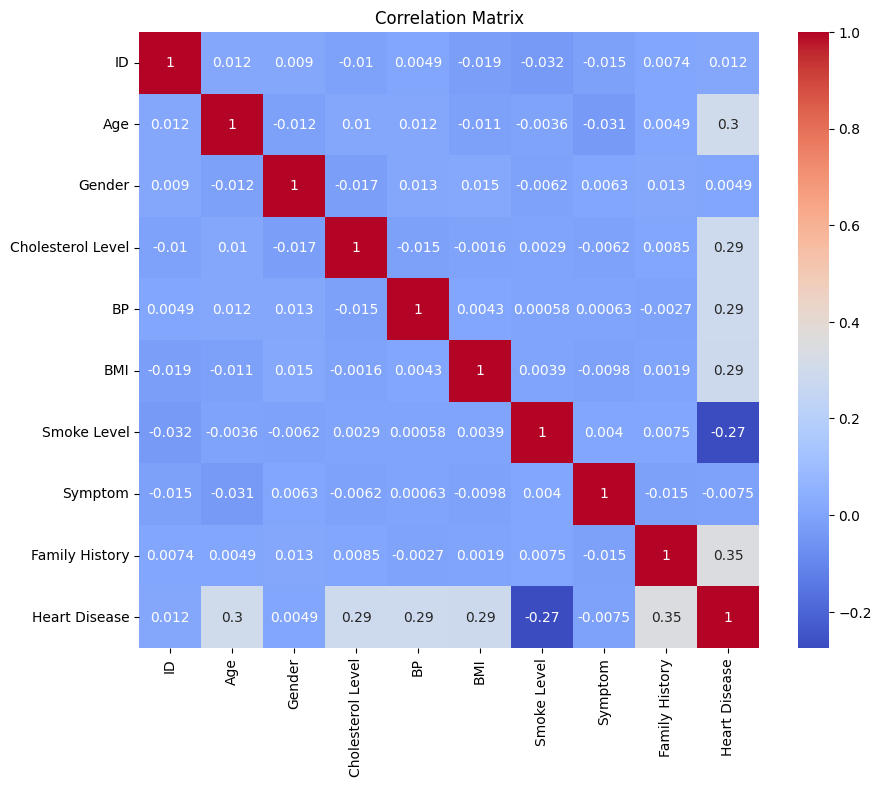

Relevant features based on correlation: ['Age', 'Cholesterol Level', 'BP', 'BMI', 'Smoke Level', 'Family History', 'Heart Disease']


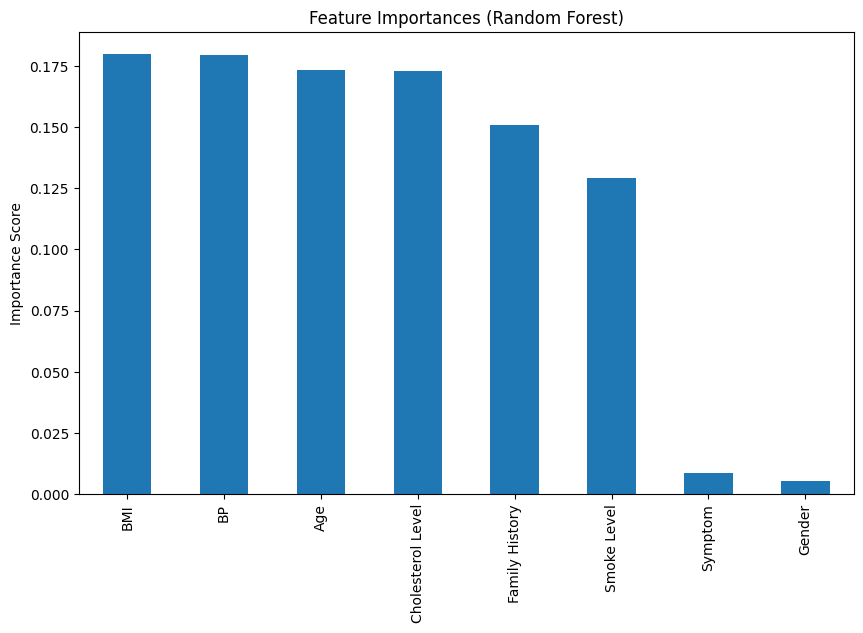

Top features based on Random Forest importance: ['BMI', 'BP', 'Age', 'Cholesterol Level', 'Family History']
Features selected by RFE: ['Age', 'Cholesterol Level', 'BP', 'BMI', 'Family History']


In [6]:


# Feature Selection
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

# Set display options to show all columns
pd.set_option('display.max_columns', None)
# 1. Correlation Matrix
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Selecting features with high correlation to the target
corr_target = corr_matrix['Heart Disease']
relevant_features = corr_target[corr_target.abs() > 0.1].index.tolist()
print("Relevant features based on correlation:", relevant_features)

# 2. Feature Importance using Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar', title="Feature Importances (Random Forest)")
plt.ylabel("Importance Score")
plt.show()

# Top features based on importance
top_features_rf = feature_importances.head(5).index.tolist()
print("Top features based on Random Forest importance:", top_features_rf)

# 3. Recursive Feature Elimination (RFE)
rfe = RFE(estimator=rf_model, n_features_to_select=5)
rfe.fit(X, y)

rfe_selected_features = X.columns[rfe.support_].tolist()
print("Features selected by RFE:", rfe_selected_features)


Model Accuracy: 99.94%


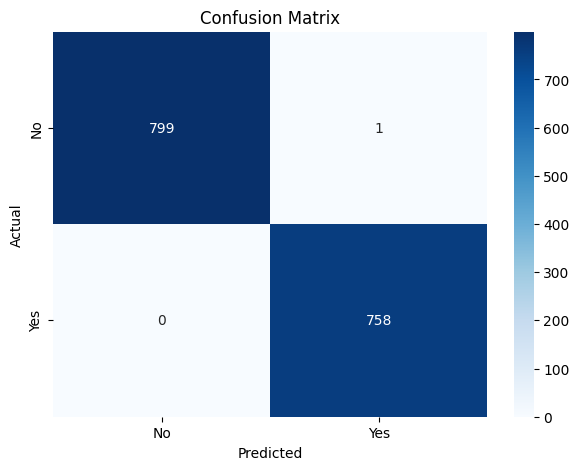

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       800
           1       1.00      1.00      1.00       758

    accuracy                           1.00      1558
   macro avg       1.00      1.00      1.00      1558
weighted avg       1.00      1.00      1.00      1558

ROC-AUC Score: 1.0000


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train_scaled, y_train)

# Predictions on the test set
y_pred = rf_model.predict(X_test_scaled)

# 1. Model Evaluation - Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 3. Classification Report (Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 4. ROC-AUC Score
roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])
print(f"ROC-AUC Score: {roc_auc:.4f}")
